In [40]:
from keras.datasets import mnist
import numpy as np
from sklearn.metrics import log_loss
from sklearn.metrics import average_precision_score as aps
from sklearn.metrics import roc_auc_score as auc
import lightgbm as lgb
import matplotlib.pyplot as plt

In [28]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [29]:
X_train = x_train.reshape(60000, 784) / 255
X_test = x_test.reshape(10000, 784) / 255

In [30]:
y_train = (y_train == 0).astype('int')
y_test = (y_test == 0).astype('int')

In [92]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

lgbm_params = {
    'objective': 'binary',
    'num_leaves': 5,
    'is_unbalance': True,
    'verbosity': -1
}

# 上記のパラメータでモデルを学習する
model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_test, num_boost_round=1)

[1]	valid_0's binary_logloss: 0.249454


In [93]:
# テストデータを予測する
def evals(X, y_true, ctr_train):
    y_pred = model.predict(X)
    y_pred_post = y_pred / (y_pred  +  (1 - ctr_train) / ctr_train  * (1 - y_pred) )
    print('logloss: %.4f' % log_loss(y_true, y_pred))
    print('logloss_post: %.4f' % log_loss(y_true, y_pred_post))
    print('auc: %.4f' % auc(y_true, y_pred))
    print('norm aps:  %.4f' % (aps(y_true, y_pred)/y_true.mean()))

In [94]:
ctr_train = np.array(y_train).mean()

In [95]:
print('-'*10)
evals(X_train, y_train, ctr_train)
print('-'*10)
evals(X_test, y_test, ctr_train)

----------
logloss: 0.2528
logloss_post: 0.3638
auc: 0.9526
norm aps:  6.7133
----------
logloss: 0.2495
logloss_post: 0.3588
auc: 0.9647
norm aps:  6.9538


In [96]:
def gen_plot_points(X, y_true, num_points=50):
    y_pred = model.predict(X) 
    scores = []
    ctrs = []
    delta = 1 / num_points
    for i in range(num_points):
        mask = (y_pred >= delta * i) * (y_pred < delta * (i +1))
        if mask.sum() > 0:
            scores.append(y_pred[mask].mean())
            ctrs.append(y_true[mask].mean())
    return scores, ctrs

In [97]:
scores_train, ctrs_train  =  gen_plot_points(X_train, y_train)
scores_test, ctrs_test  =  gen_plot_points(X_test, y_test)

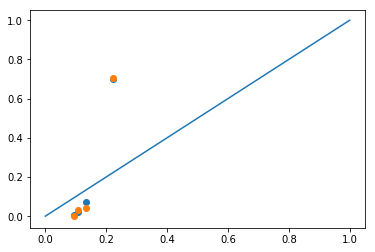

In [98]:
plt.scatter(scores_train, ctrs_train)
plt.scatter(scores_test, ctrs_test)

plt.plot([0,1], [0,1])
plt.show()

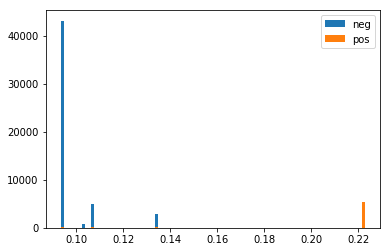

In [99]:
plt.hist(model.predict(X_train[y_train==0]) , bins=100, label='neg')
plt.hist(model.predict(X_train[y_train==1]) , bins=100, label='pos')
plt.legend()
plt.show()